# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [89]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

import lightgbm as lgb
from catboost import CatBoostRegressor

import matplotlib.pyplot as plt
import seaborn as sns

pd.options.display.float_format = '{:,.2f}'.format

## Подготовка данных

### Первичный осмотр данных

In [39]:
data = pd.read_csv(r'datasets/autos.csv')

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [41]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,"354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00","354,369.00"
mean,"4,416.66","2,004.23",110.09,"128,211.17",5.71,0.00,"50,508.69"
std,"4,514.16",90.23,189.85,"37,905.34",3.73,0.00,"25,783.10"
min,0.00,"1,000.00",0.00,"5,000.00",0.00,0.00,"1,067.00"
25%,"1,050.00","1,999.00",69.00,"125,000.00",3.00,0.00,"30,165.00"
50%,"2,700.00","2,003.00",105.00,"150,000.00",6.00,0.00,"49,413.00"
75%,"6,400.00","2,008.00",143.00,"150,000.00",9.00,0.00,"71,083.00"
max,"20,000.00","9,999.00","20,000.00","150,000.00",12.00,0.00,"99,998.00"


In [42]:
pd.DataFrame(
    [round((data.isna().mean()*100),2), data.isna().sum()]).T \
    .rename(columns={0: 'percent_na', 1: 'count_na'}) \
    .sort_values(by='count_na', ascending=False) \
    .style.background_gradient('coolwarm')

,percent_na,count_na
NotRepaired,20.080000,71154.000000
VehicleType,10.580000,37490.000000
FuelType,9.280000,32895.000000
Gearbox,5.600000,19833.000000
Model,5.560000,19705.000000
DateCrawled,0.000000,0.000000
Price,0.000000,0.000000
RegistrationYear,0.000000,0.000000
Power,0.000000,0.000000
Kilometer,0.000000,0.000000


In [43]:
data['NotRepaired'].value_counts()

no     247161
yes     36054
Name: NotRepaired, dtype: int64

In [44]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [45]:
data['FuelType'].value_counts()

petrol      216352
gasoline     98720
lpg           5310
cng            565
hybrid         233
other          204
electric        90
Name: FuelType, dtype: int64

In [46]:
data['Gearbox'].value_counts()

manual    268251
auto       66285
Name: Gearbox, dtype: int64

In [47]:
data['Model'].value_counts().head(5)

golf     29232
other    24421
3er      19761
polo     13066
corsa    12570
Name: Model, dtype: int64

In [48]:
data['NumberOfPictures'].value_counts().head(5)

0    354369
Name: NumberOfPictures, dtype: int64

In [49]:
data['RegistrationMonth'].value_counts()

0     37352
3     34373
6     31508
4     29270
5     29153
7     27213
10    26099
12    24289
11    24186
9     23813
1     23219
8     22627
2     21267
Name: RegistrationMonth, dtype: int64

### Исследование данных

<div style="border:solid blue 2.0px; padding: 10px"> 

Построим распределения значений цены, пробега и мощности для определения выбросов

</div>

In [50]:
value_dict = {
    'DateCrawled'      : 'дата скачивания анкеты из базы'                  ,
    'VehicleType'      : 'тип автомобильного кузова'                       ,
    'RegistrationYear' : 'год регистрации автомобиля'                      ,
    'Gearbox'          : 'тип коробки передач'                             ,
    'Power'            : 'мощность (л. с.)'                                ,
    'Model'            : 'модель автомобиля'                               ,
    'Kilometer'        : 'пробег (км)'                                     ,
    'RegistrationMonth': 'месяц регистрации автомобиля'                    ,
    'FuelType'         : 'тип топлива'                                     ,
    'Brand'            : 'марка автомобиля'                                ,
    'NotRepaired'      : 'была машина в ремонте или нет'                   ,
    'DateCreated'      : 'дата создания анкеты'                            ,
    'NumberOfPictures' : 'количество фотографий автомобиля'                ,
    'PostalCode'       : 'почтовый индекс владельца анкеты (пользователя)' ,
    'LastSeen'         : 'дата последней активности пользователя'          ,
    'Price'            : 'цена (евро)'
    }


In [51]:
def graph_hist_box (df, col):
    label = value_dict.get(col)
    fig, axes = plt.subplots(2, 1, figsize=(15, 8), sharex=True)
    ax1 = sns.boxplot(data = df, x=col, color="green", ax=axes[0])
    ax2 = sns.histplot(df[col], color="green", label="", kde=True, ax=axes[1])
    ax1.set(xlabel = '')
    ax2.set(xlabel = '')
    ax2.set(ylabel = 'Количество')
    plt.xlabel(label, fontsize=14)
    fig.suptitle(f'Распределение значений столбца: {label}', fontsize=20)

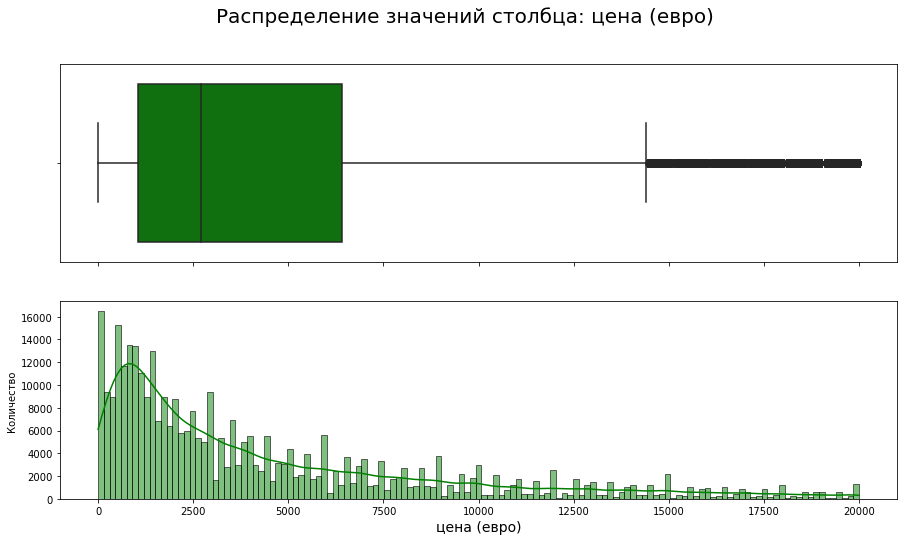

In [52]:
graph_hist_box(data, 'Price')

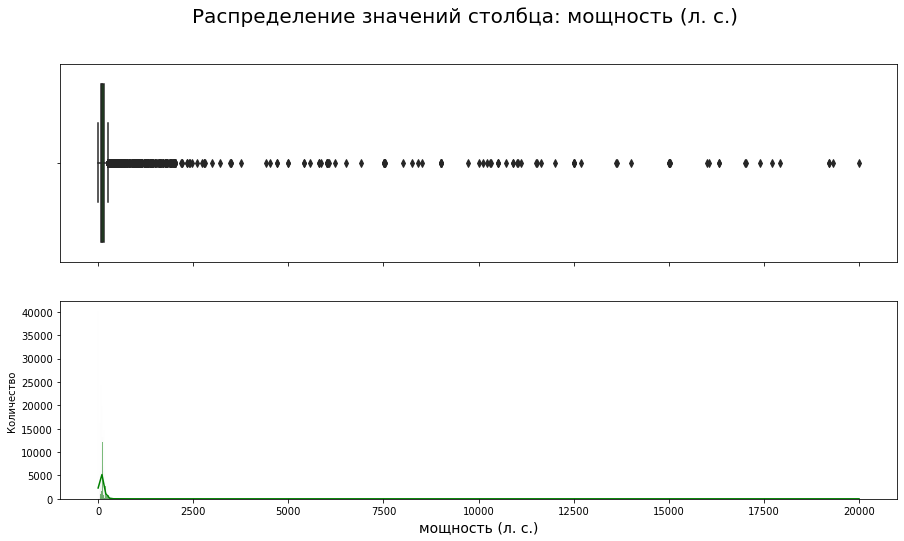

In [53]:
graph_hist_box(data, 'Power')

<div style="border:solid gray 2.0px; padding: 10px"> 

Посмотрим на график мощности по-ближе

</div>

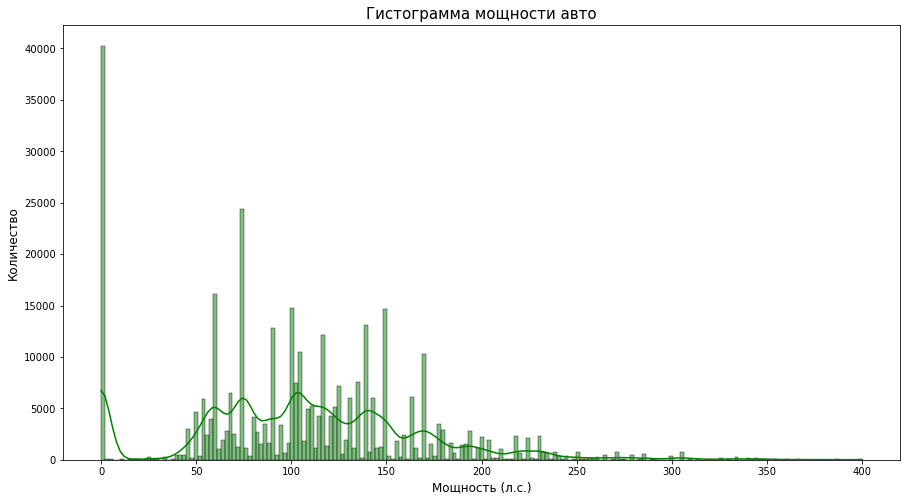

In [54]:
plt.subplots(figsize = (15,8))
Power = data.query('Power<=400')['Power']
sns.histplot(Power, color="green", label="", kde=True)
plt.xlabel('Мощность (л.с.)', fontsize = 12)
plt.ylabel('Количество', fontsize = 12)
plt.title('Гистограмма мощности авто', fontsize = 15);

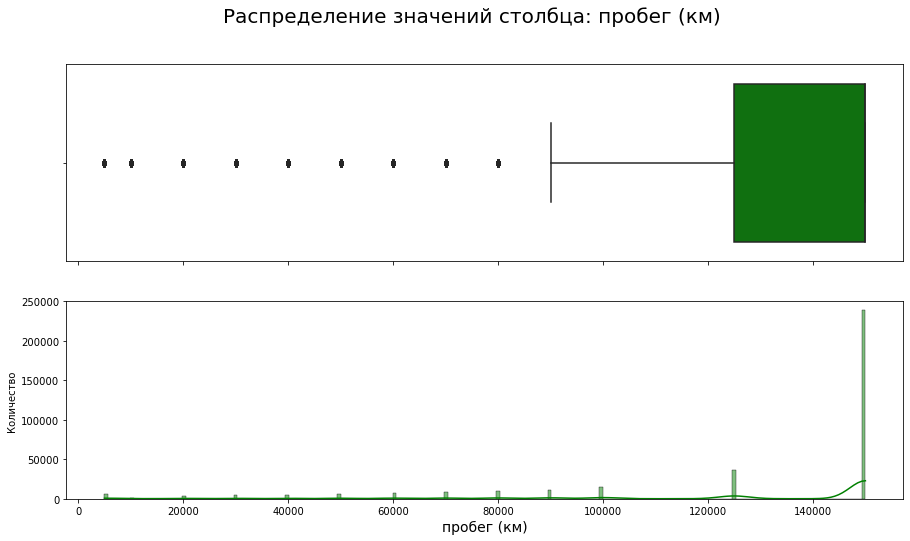

In [55]:
graph_hist_box(data, 'Kilometer')

<div style="border:solid blue 2.0px; padding: 10px"> 

 - цена: есть довольно много значений с нулевой ценой
 - мощность. видим много выбросов в сторону больших значений, а так же много значений с нулевой мощностью
 - пробег. значения вполне вменяемые

</div>

### Чистка, восстановление данных

<div style="border:solid blue 2.0px; padding: 10px"> 
    
1. Будем исходить из предположения, что наш сервис при приеме заявок сможет проверять входные данные на базовую валидность.

    За базовые проверки примем:
     - дата регистрации автомобиля не может быть раньше 1950 года
     - месяц покупки варьируется в диапазоне от 1 до 12. есть большое количество анкет с не заполненным месяцем (около 10%). чтобы такие не удалять - заполним отсутствующие данные срединным месяцем в году
     - дата регистрации автомобиля не может быть позже даты создания анкеты
     - дата создания анкеты не может быть раньше даты скачивания из базы
     - цена авто не может быть дешевле 100 евро
     - мощность авто находится в диапазоне от 10 до 1500 лс
     - модель авто (как и марка) обязательны к заполнению

    Таким обрабом, на вход будут поступать данные, проведшие первичную валидацию. Поэтому из предоставленного датасета нам так же необходимо убрать ошибочно заполненные анкеты

    
2.  Пропуски в категориальных переменных заполним значением "no answer"

</div>

In [56]:
full_sample_value = data.shape[0]

In [57]:
def check(df, rule, full_sample_value = full_sample_value):
    print(f'До проверки: {df.shape[0]} наблюдений ({round(df.shape[0]/full_sample_value*100,2)} % от исходной выборки)')
    df = df.query(rule, engine='python')
    print(f'После проверки: {df.shape[0]} наблюдений ({round(df.shape[0]/full_sample_value*100,2)} % от исходной выборки)')
    return df

In [58]:
data['RegistrationMonth'] = data['RegistrationMonth'].replace(to_replace = 0, value = 6)

In [59]:
data = check(data, 'RegistrationYear>=1950 and RegistrationYear<=2016')

До проверки: 354369 наблюдений (100.0 % от исходной выборки)
После проверки: 339593 наблюдений (95.83 % от исходной выборки)


In [60]:
data['RegistrationDate'] = pd.to_datetime(data.RegistrationYear.astype(str) + '/' + data.RegistrationMonth.astype(str) + '/01')
data['DateCreated'] = pd.to_datetime(data['DateCreated'], format='%Y-%m-%d %H:%M:%S') 

In [61]:
data = check(data, 'DateCreated>=RegistrationDate')

До проверки: 339593 наблюдений (95.83 % от исходной выборки)
После проверки: 331610 наблюдений (93.58 % от исходной выборки)


In [62]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S') 
data = check(data, 'DateCrawled>=RegistrationDate')

До проверки: 331610 наблюдений (93.58 % от исходной выборки)
После проверки: 331610 наблюдений (93.58 % от исходной выборки)


In [63]:
data = check(data, 'Price>=100')

До проверки: 331610 наблюдений (93.58 % от исходной выборки)
После проверки: 319877 наблюдений (90.27 % от исходной выборки)


In [64]:
data = check(data, 'Model.notnull()')

До проверки: 319877 наблюдений (90.27 % от исходной выборки)
После проверки: 305750 наблюдений (86.28 % от исходной выборки)


In [65]:
data = check(data, 'Power>=10 and Power<=1500')

До проверки: 305750 наблюдений (86.28 % от исходной выборки)
После проверки: 279875 наблюдений (78.98 % от исходной выборки)


In [66]:
data['NotRepaired'] = data['NotRepaired'].fillna('no answer')
data['VehicleType'] = data['VehicleType'].fillna('no answer')
data['FuelType']    = data['FuelType'].fillna('no answer')
data['Gearbox']     = data['Gearbox'].fillna('no answer')

<div style="border:solid blue 2.0px; padding: 10px"> 
Вычислим возраст авто на момент скачивания анкеты
</div>

In [67]:
data['DateCrawled'] = pd.to_datetime(data['DateCrawled'], format='%Y-%m-%d %H:%M:%S') 
data['Age'] = (data['DateCrawled']-data['RegistrationDate']).dt.days

In [68]:
value_dict['Age'] = 'Возраст авто (дней)'

In [70]:
data = data.drop(
    ['DateCrawled', 
     'PostalCode', 
     'LastSeen', 
     'RegistrationYear', 
     'RegistrationMonth', 
     'RegistrationDate', 
     'DateCreated',
     'NumberOfPictures'
    ], 
    axis=1)

In [71]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 279875 entries, 2 to 354368
Data columns (total 10 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Price        279875 non-null  int64 
 1   VehicleType  279875 non-null  object
 2   Gearbox      279875 non-null  object
 3   Power        279875 non-null  int64 
 4   Model        279875 non-null  object
 5   Kilometer    279875 non-null  int64 
 6   FuelType     279875 non-null  object
 7   Brand        279875 non-null  object
 8   NotRepaired  279875 non-null  object
 9   Age          279875 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 23.5+ MB


<div style="border:solid blue 2.0px; padding: 10px"> 
Проверим распределения после чистки
</div>

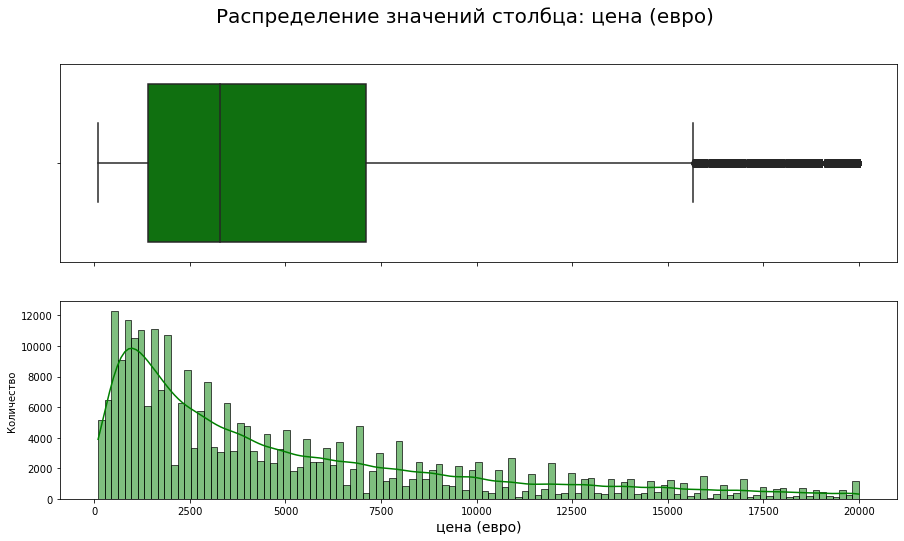

In [75]:
graph_hist_box(data, 'Price')

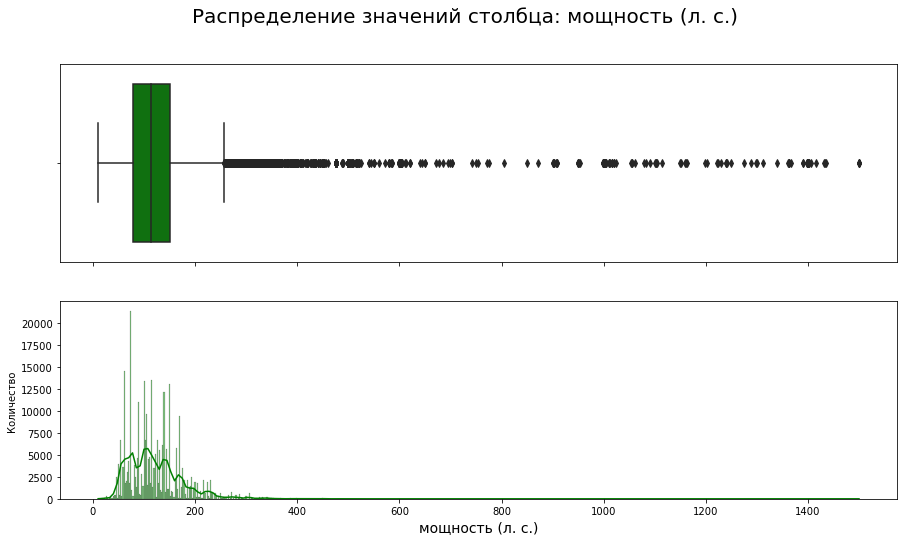

In [76]:
graph_hist_box(data, 'Power')

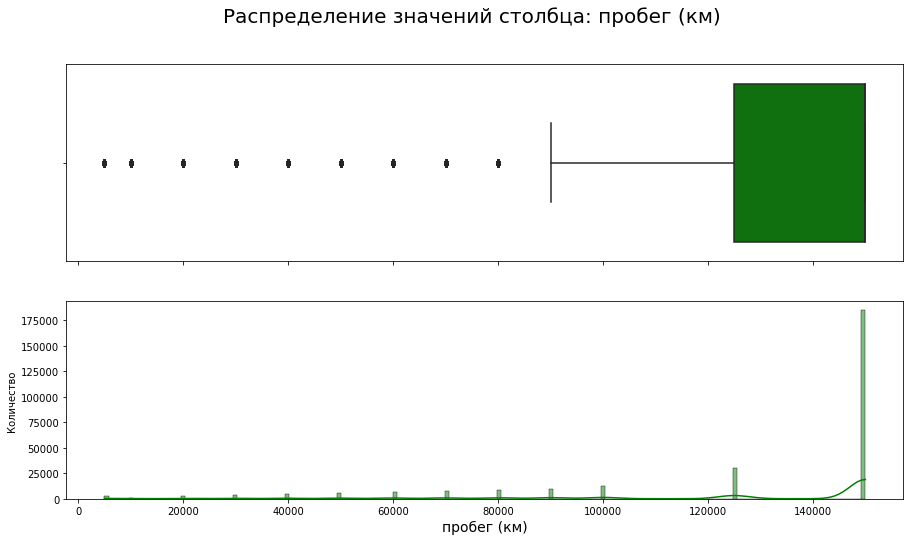

In [77]:
graph_hist_box(data, 'Kilometer')

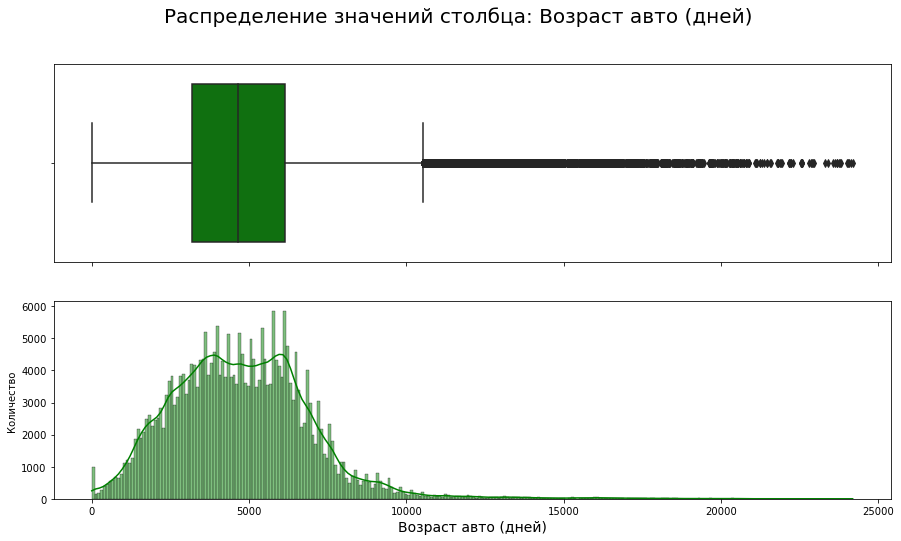

In [149]:
graph_hist_box(data, 'Age')

<div style="border:solid blue 2.0px; padding: 10px"> 
Стало лучше )
</div>

### Разбиваем на выборки

In [79]:
data_train, data_notrain = train_test_split(data, test_size=0.4, random_state=12345)
data_test, data_valid = train_test_split(data, test_size=0.5, random_state=12345)

print(f'Размер исходной выборки: {data.shape}')
print(f'Размер обучающей выборки: {data_train.shape}')
print(f'Размер валидационной выборки: {data_valid.shape}')
print(f'Размер тестовой выборки: {data_test.shape}')

Размер исходной выборки: (279875, 10)
Размер обучающей выборки: (167925, 10)
Размер валидационной выборки: (139938, 10)
Размер тестовой выборки: (139937, 10)


In [82]:
features_train = data_train.drop('Price', axis=1)
target_train = data_train['Price']

features_valid = data_valid.drop('Price', axis=1)
target_valid = data_valid['Price']

features_test = data_test.drop('Price', axis=1)
target_test = data_test['Price']

### Кодирование категориальных признаков

In [93]:
categorical_var = ['VehicleType', 'Gearbox', 'FuelType', 'NotRepaired', 'Brand', 'Model']
numeric_var = ['Power', 'Kilometer', 'Age']

#### OneHotEncoder

In [94]:
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
enc.fit(features_train[categorical_var])

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [95]:
features_train_ohe = pd.concat(
    [features_train[numeric_var],
    pd.DataFrame(enc.transform(features_train[categorical_var]), index = features_train.index)],
    axis=1
)

features_valid_ohe = pd.concat(
    [features_valid[numeric_var],
    pd.DataFrame(enc.transform(features_valid[categorical_var]), index = features_valid.index)],
    axis=1
)

features_test_ohe = pd.concat(
    [features_test[numeric_var],
    pd.DataFrame(enc.transform(features_test[categorical_var]), index = features_test.index)],
    axis=1
)

#### OrdinalEncoder

In [97]:
enc = OrdinalEncoder()
enc.fit(features_train[categorical_var])

OrdinalEncoder()

In [98]:
features_train_ore = pd.concat(
    [features_train[numeric_var],
    pd.DataFrame(enc.transform(features_train[categorical_var]), index = features_train.index)],
    axis=1
)

features_valid_ore = pd.concat(
    [features_valid[numeric_var],
    pd.DataFrame(enc.transform(features_valid[categorical_var]), index = features_valid.index)],
    axis=1
)

features_test_ore = pd.concat(
    [features_test[numeric_var],
    pd.DataFrame(enc.transform(features_test[categorical_var]), index = features_test.index)],
    axis=1
)

In [99]:
features_train_ore.head(5)

,Power,Kilometer,Age,0,1,2,3,4,5
227647,69,70000,3574,6.00,1.00,7.00,0.00,35.00,244.00
285144,140,150000,3585,8.00,0.00,5.00,0.00,37.00,170.00
39265,82,60000,1902,6.00,1.00,7.00,0.00,10.00,102.00
101910,165,150000,5680,8.00,1.00,7.00,0.00,38.00,228.00
291852,125,150000,5198,0.00,1.00,7.00,2.00,24.00,248.00


## Обучение моделей

<div style="border:solid blue 2.0px; padding: 10px"> 
    
Напишем функцию rmse_scorer, которая будет принимать на вход действительные значения и предсказания модели, а возвращать значение метрики rmse
    
</div>

In [100]:
def rmse(y_true, y_pred):
    error = (y_true - y_pred) ** 2
    return np.sqrt(np.mean(error))

rmse_scorer = make_scorer(
    rmse,
    greater_is_better=False
)

### LinearRegression

In [132]:
model = LinearRegression()
%time model.fit(features_train_ohe, target_train)

%time predict_model = model.predict(features_valid_ohe)
predict_model = pd.Series(predict_model, index=target_valid.index)
rmse_model = mean_squared_error(target_valid, predict_model)**0.5
rmse_model

Wall time: 2.4 s
Wall time: 1.23 s


2551.242247231241

### RidgeCV

In [133]:
model = RidgeCV()
%time model.fit(features_train_ohe, target_train)

%time predict_model = model.predict(features_valid_ohe)
predict_model = pd.Series(predict_model, index=target_valid.index)
rmse_model = mean_squared_error(target_valid, predict_model)**0.5
rmse_model

Wall time: 4.54 s
Wall time: 183 ms


3058.64960218366

### DecisionTreeRegressor

In [103]:
param = {
    'max_depth': range (1, 30, 2),
    'max_features': range (1, 10, 1)
       }

In [104]:
searcher = GridSearchCV(DecisionTreeRegressor(), param, scoring=rmse_scorer, cv=5)
searcher.fit(features_train_ohe, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 30, 2),
                         'max_features': range(1, 10)},
             scoring=make_scorer(rmse, greater_is_better=False))

In [105]:
searcher.best_params_

{'max_depth': 29, 'max_features': 8}

In [134]:
model = DecisionTreeRegressor(max_depth=29, max_features=8)
%time model.fit(features_train_ohe, target_train)

%time predict_model = model.predict(features_valid_ohe)
predict_model = pd.Series(predict_model, index=target_valid.index)
rmse_model = mean_squared_error(target_valid, predict_model)**0.5
rmse_model

Wall time: 759 ms
Wall time: 261 ms


2871.839042135452

### RandomForestRegressor

In [109]:
param = {
    'max_depth': range(1, 10, 2),
    'n_estimators': range(20, 100, 20)
}

In [110]:
searcher = RandomizedSearchCV(RandomForestRegressor(random_state=42), param, scoring=rmse_scorer, cv=5)
searcher.fit(features_train_ore, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42),
                   param_distributions={'max_depth': range(1, 10, 2),
                                        'n_estimators': range(20, 100, 20)},
                   scoring=make_scorer(rmse, greater_is_better=False))

In [111]:
searcher.best_params_

{'n_estimators': 80, 'max_depth': 9}

In [136]:
model = RandomForestRegressor(
    n_estimators=80,
    max_depth=9,
    random_state=42)

%time model.fit(features_train_ore, target_train)

%time predict_model = model.predict(features_valid_ore)
predict_model = pd.Series(predict_model, index=target_valid.index)
rmse_model = mean_squared_error(target_valid, predict_model)**0.5
rmse_model

Wall time: 13.9 s
Wall time: 742 ms


1886.1488132750214

### CatBoostRegressor

In [123]:
features_train_ore.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 167925 entries, 227647 to 275487
Data columns (total 9 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   Power      167925 non-null  int64  
 1   Kilometer  167925 non-null  int64  
 2   Age        167925 non-null  int64  
 3   0          167925 non-null  float64
 4   1          167925 non-null  float64
 5   2          167925 non-null  float64
 6   3          167925 non-null  float64
 7   4          167925 non-null  float64
 8   5          167925 non-null  float64
dtypes: float64(6), int64(3)
memory usage: 12.8 MB


In [124]:
target_train.head(5)

227647    5990
285144    6999
39265     6000
101910    2400
291852     999
Name: Price, dtype: int64

In [125]:
from catboost import CatBoostRegressor

In [126]:
grid = {'learning_rate': [0.1],
        'depth': [2, 4 ,6, 8, 10],
        'l2_leaf_reg': [1, 3],
        'iterations': [1000]}

In [127]:
model = CatBoostRegressor(loss_function='RMSE', verbose=50)

In [128]:
grid_search_result = model.grid_search(grid,
                                       X=features_train_ore,
                                       y=target_train)

0:	learn: 6263.8238310	test: 6212.1243841	best: 6212.1243841 (0)	total: 156ms	remaining: 2m 35s
50:	learn: 2275.2345413	test: 2257.8174165	best: 2257.8174165 (50)	total: 416ms	remaining: 7.74s
100:	learn: 2095.7327857	test: 2085.1159905	best: 2085.1159905 (100)	total: 645ms	remaining: 5.74s
150:	learn: 2003.8732210	test: 1997.6924437	best: 1997.6924437 (150)	total: 882ms	remaining: 4.96s
200:	learn: 1944.4252023	test: 1942.9699179	best: 1942.9699179 (200)	total: 1.13s	remaining: 4.49s
250:	learn: 1905.5314620	test: 1907.1755845	best: 1907.1755845 (250)	total: 1.38s	remaining: 4.11s
300:	learn: 1878.0396789	test: 1881.3558423	best: 1881.3558423 (300)	total: 1.61s	remaining: 3.73s
350:	learn: 1856.6794824	test: 1861.7554229	best: 1861.7554229 (350)	total: 1.85s	remaining: 3.42s
400:	learn: 1840.4397091	test: 1846.7437571	best: 1846.7437571 (400)	total: 2.1s	remaining: 3.14s
450:	learn: 1826.3527702	test: 1833.7199396	best: 1833.7199396 (450)	total: 2.36s	remaining: 2.88s
500:	learn: 1814

In [129]:
grid_search_result['params']

{'depth': 10, 'l2_leaf_reg': 1, 'iterations': 1000, 'learning_rate': 0.1}

In [137]:
model = CatBoostRegressor(loss_function='RMSE', iterations=1000, depth=10, l2_leaf_reg=1, learning_rate=0.1) 
%time model.fit(features_train_ore, target_train, verbose=200) 

%time predict_model = model.predict(features_valid_ore)
rmse_model = mean_squared_error(target_valid, predict_model)**0.5
rmse_model

0:	learn: 4295.3468560	total: 26.1ms	remaining: 26.1s
200:	learn: 1476.1485967	total: 4.41s	remaining: 17.5s
400:	learn: 1369.4288540	total: 8.72s	remaining: 13s
600:	learn: 1306.8781449	total: 13s	remaining: 8.65s
800:	learn: 1260.9007109	total: 17.5s	remaining: 4.36s
999:	learn: 1224.2008557	total: 22s	remaining: 0us
Wall time: 22.5 s
Wall time: 172 ms


1442.406440530502

### Lightgbm

In [140]:
for cat in categorical_var:
    features_train[cat] = features_train[cat].astype('category')
    features_test[cat] = features_test[cat].astype('category')
    features_valid[cat] = features_valid[cat].astype('category')    

In [141]:
params = {
    'objective': ['regression'], 
    'learning_rate': [0.1],
    'num_leaves': range(10, 100, 20),
    'max_depth': [2, 4, 6, 8, 10],
    'subsample': [0.8], 
    'colsample_bytree': [0.8]
    }

In [142]:
model = lgb.LGBMRegressor()
gsearch = GridSearchCV(estimator=model, param_grid=params, scoring=rmse_scorer, cv=5)
gsearch.fit(features_train_ore, target_train)
gsearch.best_params_, gsearch.best_score_

({'colsample_bytree': 0.8,
  'learning_rate': 0.1,
  'max_depth': 10,
  'num_leaves': 90,
  'objective': 'regression',
  'subsample': 0.8},
 -1569.2121757666162)

In [144]:
model = lgb.LGBMRegressor(
    colsample_bytree = 0.8,
    learning_rate = 0.1,
    max_depth = 10,
    num_leaves = 90,
    objective = 'regression',
    subsample = 0.8
)

%time model.fit(features_train_ore, target_train)
%time predict_model = model.predict(features_valid_ore)
rmse_model = mean_squared_error(target_valid, predict_model)**0.5
rmse_model

Wall time: 334 ms
Wall time: 93.7 ms


1549.2238176692188

## Анализ моделей

### Общий анализ

<div style="border:solid blue 2.0px; padding: 10px"> 
    
Соберем данные о времени обучения и предсказания в одном месте

</div>

In [146]:
fit_predict_time = pd.DataFrame(columns=['model', 'fit_time', 'predict time', 'rmse'])

In [147]:
fit_predict_time.loc[len(fit_predict_time)] = ['LinearRegression'     , 2.4,   1.23,  2551]
fit_predict_time.loc[len(fit_predict_time)] = ['RidgeCV'              , 4.5,   0.18,  3058]
fit_predict_time.loc[len(fit_predict_time)] = ['DecisionTreeRegressor', 0.76,  0.261, 2871]
fit_predict_time.loc[len(fit_predict_time)] = ['RandomForestRegressor', 13.9,  0.762, 1886]
fit_predict_time.loc[len(fit_predict_time)] = ['CatBoostRegressor'    , 22.5,  0.172, 1442]
fit_predict_time.loc[len(fit_predict_time)] = ['LGBMRegressor'        , 0.33,  0.094, 1549]

In [148]:
fit_predict_time

,model,fit_time,predict time,rmse
0,LinearRegression,2.40,1.23,2551
1,RidgeCV,4.50,0.18,3058
2,DecisionTreeRegressor,0.76,0.26,2871
3,RandomForestRegressor,13.90,0.76,1886
4,CatBoostRegressor,22.50,0.17,1442
5,LGBMRegressor,0.33,0.09,1549


<div style="border:solid blue 2.0px; padding: 10px"> 

**Оценим** модели по нескольким параметрам:
 - быстрейшее время обучения показали модели LGBMRegressor и DecisionTreeRegressor
 - быстрейшее время предсказания показывают модель LGBMRegressor
 - лучшее качество предсказания показали модели CatBoostRegressor и LGBMRegressor

<span style="color: white">. </span>   
    
Выделим **три модели** с точки зения качества и проверим на тестовой выборке.
Это:
 - **RandomForestRegressor** c параметрами:
    - n_estimators = 80
    - max_depth=9

    
 - **CatBoostRegressor** c параметрами:
    - depth = 10
    - l2_leaf_reg = 1
    - iterations = 1000
    - learning_rate = 0.1

    
 - **LGBMRegressor** c параметрами:
    - colsample_bytree = 0.8
    - learning_rate = 0.1
    - max_depth = 10
    - num_leaves = 90
    - objective = 'regression'
    - subsample = 0.8
    
</div>

### Проверка на тестовой выборке

#### RandomForestRegressor

In [150]:
model = RandomForestRegressor(
    n_estimators=80,
    max_depth=9,
    random_state=42)

%time model.fit(features_train_ore, target_train)

%time predict_model = model.predict(features_test_ore)
predict_model = pd.Series(predict_model, index=target_test.index)
rmse_model = mean_squared_error(target_test, predict_model)**0.5
rmse_model

Wall time: 13.4 s
Wall time: 719 ms


1826.2059454479804

#### CatBoostRegressor

In [151]:
model = CatBoostRegressor(loss_function='RMSE', iterations=1000, depth=10, l2_leaf_reg=1, learning_rate=0.1) 
%time model.fit(features_train_ore, target_train, verbose=200) 

%time predict_model = model.predict(features_test_ore)
rmse_model = mean_squared_error(target_test, predict_model)**0.5
rmse_model

0:	learn: 4295.3468560	total: 24ms	remaining: 24s
200:	learn: 1476.1485967	total: 4.52s	remaining: 18s
400:	learn: 1369.4288540	total: 9.02s	remaining: 13.5s
600:	learn: 1306.8781449	total: 13.5s	remaining: 8.97s
800:	learn: 1260.9007109	total: 17.9s	remaining: 4.46s
999:	learn: 1224.2008557	total: 22.6s	remaining: 0us
Wall time: 23.2 s
Wall time: 165 ms


1222.4708454028262

#### Lightgbm

In [152]:
model = lgb.LGBMRegressor(
    colsample_bytree = 0.8,
    learning_rate = 0.1,
    max_depth = 10,
    num_leaves = 90,
    objective = 'regression',
    subsample = 0.8
)

%time model.fit(features_train_ore, target_train)
%time predict_model = model.predict(features_test_ore)
rmse_model = mean_squared_error(target_test, predict_model)**0.5
rmse_model

Wall time: 340 ms
Wall time: 78.1 ms


1481.5199666031842

## Вывод

<div style="border:solid blue 2.0px; padding: 10px"> 

В процессе проекта мы выяснили, для нашей задачи регресии разные модели показали себя по-разному.

Тройка наилучших моделей: RandomForestRegressor, CatBoostRegressor, LGBMRegressor
 - лучшая модель с точки зрения качества CatBoostRegressor
 - модель LGBMRegressor не сильно проигрывает в качестве, но является быстрейшей по обучению и предсказанию
 - модель RandomForestRegressor уступает в скорости CatBoostRegressor, но выигрывает у CatBoostRegressor. Качество модели хучшее из тройки
 

По совокупности параметров, **лучше всего себя показала модель LGBMRegressor**
Она показывает хорошее качетво, не сильно уступая CatBoostRegressor, но является быстрейшей с явным преимущестовм.

</div>